In [1]:
%matplotlib inline
import glob
import scipy.io
import numpy as np
import math
import os
import csv
import umap
import sklearn.datasets
import pandas as pd
import h5py
import umap
import re
import umap.plot
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import colorsys
import matplotlib.colors as pltcolors
import plotly.graph_objects as go
from IPython.display import clear_output
from bokeh.models import Button
from bokeh.io import curdoc
from soundsig.sound import WavFile, BioSound
from IPython.display import Audio
from soundsig.signal import bandpass_filter
from soundsig.sound import spectrogram, plot_spectrogram, log_transform, play_sound_array
from ipywidgets import Output

In [2]:
def load_mat(filename):
    """
    This function should be called instead of scipy.io.loadmat
    as it can recover python dictionaries from mat files.
    """

    def _check_keys(d):
        """
        Checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        """
        for key in d:
            if isinstance(d[key], scipy.io.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        """
        A recursive function which constructs from matobjects nested dictionaries
        """
        nested_d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, scipy.io.matlab.mio5_params.mat_struct):
                nested_d[strg] = _todict(elem)
            else:
                nested_d[strg] = elem
        return nested_d

    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def open_files(paths):
    print("-- Finding all matfiles --")
    mat_objs = []
    for path in paths:
        print(str(path + "/*.mat"))
        Listing = glob.glob(str(path + "/*.mat"))
        print(Listing[0])
        for file in Listing:
#        for file in os.listdir(path):
            if file.endswith("200.mat"):
                mat_objs.append(load_mat(str(file)))
    print("-- Done finding all matfiles --")
    return mat_objs

def collect_data_mps(mat_objs):
    collected_data = []
    wf, wt = mat_objs[0]['BioSoundCalls'][0][0].wf, mat_objs[0]['BioSoundCalls'][0][0].wt
    w0 = next(x[0] for x in enumerate(wf) if x[1] > 0)
    w1 = next(x[0] for x in enumerate(wf) if x[1] > 0.0025)
    t0 = next(x[0] for x in enumerate(wt) if x[1] > -200)
    t1 = next(x[0] for x in enumerate(wt) if x[1] > 200)
    for mat_obj in mat_objs:
        if 'BioSoundCalls' not in mat_obj.keys():
            continue
        specs = mat_obj['BioSoundCalls']
        if len(specs) > 0 and not isinstance(specs[0], np.ndarray):
            specs = [specs]
        for row in specs:
            try:
                collected_data.append(row[0].mps[w0:w1, t0:t1].flatten())
            except:
                continue
    print("---- Collected MPS sounds ----")
    return l2_norm(np.vstack(collected_data))

def collect(mat_objs): # This function collects ids
    collected_ids = []
    collected_data = []
    wf, wt = mat_objs[0]['BioSoundCalls'][0][0].wf, mat_objs[0]['BioSoundCalls'][0][0].wt
    w0 = next(x[0] for x in enumerate(wf) if x[1] > 0)
    w1 = next(x[0] for x in enumerate(wf) if x[1] > 0.0025)
    t0 = next(x[0] for x in enumerate(wt) if x[1] > -200)
    t1 = next(x[0] for x in enumerate(wt) if x[1] > 200)
    for mat_obj in mat_objs:
        if 'BioSoundFilenames' not in mat_obj.keys() or 'BioSoundCalls' not in mat_obj.keys():
            continue
        
        filenames = mat_obj['BioSoundFilenames']
        if len(filenames) > 0 and filenames.ndim == 1:
            filenames = [filenames]
        
        specs = mat_obj['BioSoundCalls']
        if len(specs) > 0 and not isinstance(specs[0], np.ndarray):
            specs = [specs]
        
        for row_id, row in zip(filenames, specs):
            name = row_id[0]
            try:
                collected_data.append(row[0].mps[w0:w1, t0:t1].flatten())
                x = re.search("Bat\d*", name)
            except (TypeError, AttributeError):
                continue
            name = name[x.start() + 3:x.end()]
            if type(name) == str:
                collected_ids.append(name)
    
    print("---- Collected Mat_objects ----")
    y_set = set(collected_ids)
    hashed_y = {}
    for i, val in enumerate(y_set):
        hashed_y[val] = i
    hashed = lambda x: int(hashed_y[x])
    return np.array(list(y_set)), np.array(collected_ids), l2_norm(np.vstack(collected_data)) # corresponds respectively to y, y_ids and voc_data when called below?

In [3]:
def l2_norm(mats):
    return mats / np.linalg.norm(mats, axis=0)

def avged_norm(mats):
    return (mats - np.min(mats, axis=0)) / (np.max(mats, axis=0) - np.min(mats, axis=0))

In [64]:
def spec_colormap():
# Makes the colormap that we like for spectrograms

    cmap = np.zeros((64,3))
    cmap[0,2] = 1.0

    for ib in range(21):
        cmap[ib+1,0] = (31.0+ib*(12.0/20.0))/60.0
        cmap[ib+1,1] = (ib+1.0)/21.0
        cmap[ib+1,2] = 1.0

    for ig in range(21):
        cmap[ig+ib+1,0] = (21.0-(ig)*(12.0/20.0))/60.0
        cmap[ig+ib+1,1] = 1.0
        cmap[ig+ib+1,2] = 0.5+(ig)*(0.3/20.0)

    for ir in range(21):
        cmap[ir+ig+ib+1,0] = (8.0-(ir)*(7.0/20.0))/60.0
        cmap[ir+ig+ib+1,1] = 0.5 + (ir)*(0.5/20.0)
        cmap[ir+ig+ib+1,2] = 1

    for ic in range(64):
        (cmap[ic,0], cmap[ic,1], cmap[ic,2]) = colorsys.hsv_to_rgb(cmap[ic,0], cmap[ic,1], cmap[ic,2])
    
    spec_cmap = pltcolors.ListedColormap(cmap, name=u'SpectroColorMap', N=64)
    plt.register_cmap(cmap=spec_cmap, override_builtin=1)

def plot_spectro(t, freq, spec, ax=None, ticks=True, fmin=None, fmax=None, colormap=None, colorbar=True, log = True, dBNoise = 50):
            if colormap == None:
                spec_colormap()
                colormap = plt.get_cmap('SpectroColorMap')

            if ax is None:
                ax = plt.gca()

            if fmin is None:
                fmin = freq.min()
            if fmax is None:
                fmax = freq.max()

            ex = (t.min(), t.max(), freq.min(), freq.max())
            plotSpect = np.abs(spec)


            if log == True and dBNoise is not None:
                plotSpect = 20*np.log10(plotSpect)
                maxB = plotSpect.max()
                minB = maxB-dBNoise
            else:
                if dBNoise is not None:
                    maxB = 20*np.log10(plotSpect.max())
                    minB = ((maxB-dBNoise)/20.0)**10
                else:
                    maxB = plotSpect.max()
                    minB = plotSpect.min()

            plotSpect[plotSpect < minB] = minB

            return ax, ex, colormap, minB, maxB, plotSpect, fmin, fmax, ticks, colorbar
        
def plot_spectrom(ind, ax=None):
#    spectro = bioSound_objs_list[ind].spectro/20
#    spectro = 10**(spectro)
    Ref_spec = Sound_Data['Spectro'][0][ind]
    spectro = np.array(Sound_Data[Ref_spec])
    spectro = 10**((spectro.T)/20)
    Ref_fo = Sound_Data['Spectro_fo'][0][ind]
    Fo = np.array(Sound_Data[Ref_fo])
    Ref_to = Sound_Data['Spectro_to'][0][ind]
    To = np.array(Sound_Data[Ref_to])
#    return plot_spectro(bioSound_objs_list[ind].to, bioSound_objs_list[ind].fo, spectro, ax=ax, dBNoise=60)
    return plot_spectro(To, Fo, spectro, ax=ax, dBNoise=60)

def interactive_plot(u=None, s=None, colornum=None, n_neighbors=10, min_dist=0.1, n_components=2, metric='euclidean', title='', ax=None):
#    you can input your own projection values in u
#    if u == None:
#        fit = umap.UMAP(
#            n_neighbors=n_neighbors,
#            min_dist=min_dist,
#            n_components=n_components,
#            metric=metric
#        )
#        u = fit.fit_transform(voc_data);

    f = go.FigureWidget([go.Scatter(
        x=u[:,0], 
        y=u[:,1], 
        mode='markers',
        customdata=iph_pd[['index', 'label', 'batID']],
        hovertemplate = "<br>".join(["index: %{customdata[0]}", 
                                     "label: %{customdata[1]}",
                                     "batID: %{customdata[2]}<extra></extra>"])
    )])
    scatter = f.data[0]
    # Set the values for the point color. Use y (ID of bats coded as integers between 0:Numbats) as default
#    if c == None:
#        scatter.marker.color = y
    scatter.marker.color = colornum
#     print(len(y), y)
    f.layout.hovermode = 'closest'
#     Audio(bioSound_objs_list[0].sound, rate=bioSound_objs_list[0].samprate, autoplay=True)
    plt.ion()
    ax = None
    iax = None
    out = Output()
    display(out)
    
    def update_point(trace, points, selector):
        nonlocal ax
        nonlocal iax
        nonlocal out
#         c = list(scatter.marker.color)
#         s = list(scatter.marker.size)
#         print(c, s, len(c))
        for i in points.point_inds:
            if iax != None:
                with out:
                    clear_output(wait=True)
            if ax == None:
                ax, ex, colormap, minB, maxB, plotSpect, fmin, fmax, ticks, colorbar = plot_spectrom(i, ax)
                with out:
                    iax = ax.imshow(plotSpect, aspect='auto', interpolation='nearest', origin='lower', extent=ex, cmap=colormap, vmin=minB, vmax=maxB)
                    ax.set_ylim(fmin, fmax)
                    if not ticks:
                        ax.set_xticks([])
                        ax.set_yticks([])
                    else:
                        ax.set_ylabel('Frequency (Hz)')
                        ax.set_xlabel('Time (s)')

                    if colorbar:
                        plt.colorbar(iax)
                    play_audio(i)
            else:
                ax, ex, colormap, minB, maxB, plotSpect, fmin, fmax, ticks, colorbar = plot_spectrom(i, ax)
                with out:
                    iax = ax.imshow(plotSpect, aspect='auto', interpolation='nearest', origin='lower', extent=ex, cmap=colormap, vmin=minB, vmax=maxB)
                    plt.sca(ax)
                    plt.show()
                    play_audio(i)
#             c[i] = '#bae2be' 
#             s[i] = 20
#             with f.batch_update():
#                 scatter.marker.color = c
#                 scatter.marker.size = s
    scatter.on_click(update_point)
    
    return f

def collect_bioSound_objs(root=None, files=None): # collects all biosound objects (including spectro)
    if files: # make it compatible with Deaf bats dataset
        if root == None:
            root = os.getcwd()
        files = files if isinstance(files, list) else [files]
        paths = [root + file for file in files]
        print(" --> Collecting Data in:")
        print(paths)
        mat_objs = open_files(paths)
        print("Number of mat_objs")
        print(len(mat_objs))
        collected_ids = []
        collected_data = []
 #       FileCounter = 0
        
        for mat_obj in mat_objs:
 #           FileCounter = FileCounter + 1
 #           print(FileCounter)
            if 'BioSoundFilenames' not in mat_obj.keys() or 'BioSoundCalls' not in mat_obj.keys():
                continue
        
            filenames = mat_obj['BioSoundFilenames']
            if len(filenames) > 0 and filenames.ndim == 1:
                filenames = [filenames]
        
            specs = mat_obj['BioSoundCalls']
            if len(specs) > 0 and not isinstance(specs[0], np.ndarray):
                specs = [specs]
        
            for row_id, row in zip(filenames, specs):
                if row[0] != [] and 'mps' in row[0]._fieldnames:
                    name = row_id[0]
                    try:
                        collected_data.append(row[0])
                        x = re.search("Bat\d*", name)
                    except (TypeError, AttributeError):
                        continue
                    name = name[x.start() + 3:x.end()]
                    if type(name) == str:
                        collected_ids.append(name)
    
        print("---- Collected Biosound Objects ----")
        y_array = np.array(collected_ids)
        y_set = set(y_array)
        hashed_y = {}
        for i, val in enumerate(y_set):
            hashed_y[val] = i
        y = np.vectorize(hashed_y.get)(y_array)
        
    return collected_data, collected_ids, y

def play_audio(index):
#      sound > 100 --> pad zeros (np.pad)
#    sound = bioSound_objs_list[index].sound - np.mean(bioSound_objs_list[index].sound)
#    sound = sound / np.std(bioSound_objs_list[index].sound)
#    display(Audio(sound, rate=bioSound_objs_list[index].samprate, autoplay=True))
    ref_voc = Sound_Data['Sound'][0][index]
    voc = np.array(Sound_Data[ref_voc])
    voc = (voc - np.mean(voc)) / np.std(voc)
    # Get the sampling rate
    samprate = np.array(Sound_Data['SampleRate'][0])[0]
    display(Audio(voc, rate=samprate, autoplay=True))

In [65]:
# Data location on Julie's Machine
LocalDataDir = '/Users/elie/Documents/DeafBats/Data/'
# Data location on the server
BaseDataDir = '/Volumes/server_home/users/JulieE/DeafSalineGroup151'
myDir = LocalDataDir
# Load spectro and BatID that have been collected by DeafBats_PythonPlot_DataGather.mlx
Sound_Data = h5py.File(os.path.join(myDir, 'PiezoData4_DeafBats_PythonPlot.mat'), 'r')
Sound_Data.keys()



<KeysViewHDF5 ['#refs#', 'ALID', 'BatID', 'CallDate', 'CallType', 'MicFileNum', 'MicFileSampleID', 'OnSetOffsetSample', 'SampleRate', 'Sound', 'Spectro', 'Spectro_fo', 'Spectro_to']>

In [66]:
# Querry a particular spectro
Ref_spec = Sound_Data['Spectro'][0][100]
Spectro = np.array(Sound_Data[Ref_spec])
Ref_fo = Sound_Data['Spectro_fo'][0][100]
Fo = np.array(Sound_Data[Ref_fo])
Fo.flatten()
Ref_to = Sound_Data['Spectro_to'][0][100]
To = np.array(Sound_Data[Ref_to])
To.flatten()

print(Spectro.shape)
print(To.shape)
print(Fo.shape)
Spectro.T.shape

(31, 94)
(31, 1)
(94, 1)


(94, 31)

In [67]:
# Get the list of BatID
BatsID = Sound_Data['BatID'][0]

print(BatsID.shape)
print(len(BatsID))
BatsID

(28091,)
28091


array([71047., 14461., 14461., ..., 71043., 71043., 71043.])

In [68]:
# Get the sampling rate
samprate = np.array(Sound_Data['SampleRate'][0])[0]
samprate

50000.0

In [69]:
# Get a particular vocalization, very short voclaiztaions don't through error but don't play,
# while longer vocalization (e.g. indices 0 or 15) through an error
ref_voc = Sound_Data['Sound'][0][10]
voc = np.array(Sound_Data[ref_voc])
voc = (voc - np.mean(voc)) / np.std(voc)
print(voc.shape)
print(voc.dtype)
#play the voc
display(Audio(voc, rate=samprate, autoplay=True))

(2651, 1)
float64


In [71]:
# Load the projection values calculated before in Matlab
UMAP_Data = scipy.io.loadmat(os.path.join(myDir,'Data4_DeafBats_CatCalls.mat'), variable_names = ['MPSmicReduction4Clustering', 'TmicAll7'])
print(UMAP_Data.keys())
UMAP_Projection = UMAP_Data['MPSmicReduction4Clustering']
AcGroup = UMAP_Data['TmicAll7']


# print(len(UMAP_Projection))
print('Projection matrix type')
print(UMAP_Projection.dtype)
print('Projection matrix shape')
print(UMAP_Projection.shape)
print('Projection matrix size')
print(UMAP_Projection.size)
print('Acoustic group vector type')
print(AcGroup.dtype)
print('Acoustic group vector shape')
print(AcGroup.shape)
print('Acoustic group vector size')
print(AcGroup.size)
Indices = np.arange(len(BatsID))
print('Indices vector type')
print(Indices.dtype)
print('Indices vector shape')
print(Indices.shape)
print('Indices vector size')
print(Indices.size)

dict_keys(['__header__', '__version__', '__globals__', 'MPSmicReduction4Clustering', 'TmicAll7'])
Projection matrix type
float64
Projection matrix shape
(28091, 3)
Projection matrix size
84273
Acoustic group vector type
uint8
Acoustic group vector shape
(28091, 1)
Acoustic group vector size
28091
Indices vector type
int64
Indices vector shape
(28091,)
Indices vector size
28091


In [72]:
# getting the hovering data organized
hover_data = pd.DataFrame({'index':np.arange(len(BatsID)),
                           'label':np.squeeze(AcGroup), 'batID':np.squeeze(BatsID)}) 

iph = hover_data.to_dict()
dict_idx = list(iph['index'].values())
iph['index'] = dict_idx
dict_lbl = list(iph['label'].values())
iph['label'] = dict_lbl
dict_batID = list(iph['batID'].values())
iph['batID'] = dict_batID
iph_pd = pd.DataFrame.from_dict(iph)

Output()

FigureWidget({
    'data': [{'customdata': array([[0.0000e+00, 1.0000e+00, 7.1047e+04],
                      …

/var/folders/87/vb4sm2kn10vfzxnyrz__96780000gq/T/ipykernel_9820/3993853164.py:26: MatplotlibDeprecationWarning:

The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.

/var/folders/87/vb4sm2kn10vfzxnyrz__96780000gq/T/ipykernel_9820/3993853164.py:26: UserWarning:

Overwriting the cmap 'SpectroColorMap' that was already in the registry.



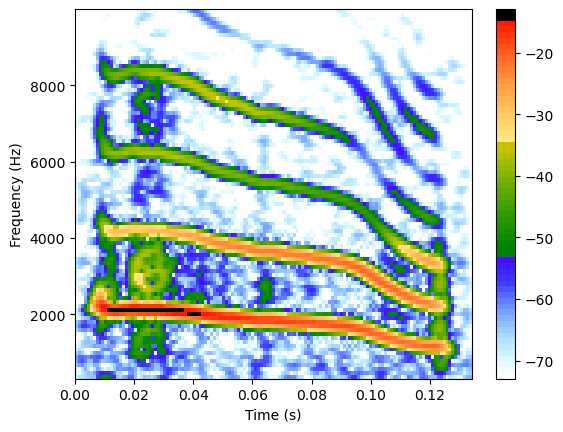

/var/folders/87/vb4sm2kn10vfzxnyrz__96780000gq/T/ipykernel_9820/3993853164.py:26: MatplotlibDeprecationWarning:

The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.

/var/folders/87/vb4sm2kn10vfzxnyrz__96780000gq/T/ipykernel_9820/3993853164.py:26: UserWarning:

Overwriting the cmap 'SpectroColorMap' that was already in the registry.

/var/folders/87/vb4sm2kn10vfzxnyrz__96780000gq/T/ipykernel_9820/3993853164.py:26: MatplotlibDeprecationWarning:

The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.

/var/folders/87/vb4sm2kn10vfzxnyrz__96780000gq/T/ipykernel_9820/3993853164.py:26: UserWarning:

Overwriting the cmap 'SpectroColorMap' that was already in the registry.

/var/folders/87/vb4sm2kn10vfzxnyrz__96780000gq/T/ipykernel_9820/3993853164.py:26: MatplotlibDeprecationWarning:

T

In [75]:
# Call the interactive plot on these data and projections
f = interactive_plot(u=UMAP_Projection, s=Sound_Data, colornum=AcGroup)
f